## Autoencoder
### 1. Discrete autoencoder using Prescribed Error Sensitivity (PES) plasticity rule

They are linked together by the following processes
<table>
    <tr>
        <td><p align="left"> Encoding </p></td>
        <td><p align="left"> $V_i^H(t) = \frac{V_0 - V_i^H(t)}{\tau_V} - T_i S_i^H(t) + \sum_i W^{\mathrm{ENC}}_{ij} S_j^I(t)$ </p></td>
    </tr>
    <tr>
        <td><p align="left"> Decoding </p></td>
        <td><p align="left"> $V_i^O(t) = \frac{V_0 - V_i^O(t)}{\tau_V} - T_i S_i^O(t) + \sum_i W^{\mathrm{DEC}}_{ij} S_j^H(t)$ </p></td>
    </tr>
    <tr>
        <td><p align="left"> PES rule </p></td>
        <td><p align="left"> $\dot{W}^{\mathrm{DEC}}_{ij} = \alpha (R_i^I(t) - R_i^O(t)) R_j^H(t)$ </p></td>
    </tr>
</table>

Problem 1: In the design, the error signal targets the synapse, for which there is no obvious biological mechanism. Potential solution is to compute the error directly instead of the output. Then the weight can be adapted directly based on pre and post-synaptic activities of the decoding weights.

<table>
    <tr>
        <td><p align="left"> Encoding </p></td>
        <td><p align="left"> $V_i^H(t) = \frac{V_0 - V_i^H(t)}{\tau_V} - T_i S_i^H(t) + \sum_i W^{\mathrm{ENC}}_{ij} S_j^I(t)$ </p></td>
    </tr>
    <tr>
        <td><p align="left"> Decoding </p></td>
        <td><p align="left"> $V_i^O(t) = \frac{V_0 - V_i^O(t)}{\tau_V} - T_i S_i^O(t) + \sum_i W^{\mathrm{DEC}}_{ij} S_j^H(t) - S_i^I(t) + N_i(t)$ </p></td>
    </tr>
    <tr>
        <td><p align="left"> PES rule </p></td>
        <td><p align="left"> $\dot{W}^{\mathrm{DEC}}_{ij} = \alpha (R_0 - R_i^O(t)) R_j^H(t)$ </p></td>
    </tr>
</table>

**Challenges**: Input-err pathway produces much less spikes than enc-dec pathway. Not possible to compensate simply by weights.

In [1]:
# Import libraries from outside folder
import sys
sys.path.append('../lib/')

import numpy as np
import matplotlib.pyplot as plt

from brian2 import start_scope, prefs, run
from brian2 import NeuronGroup, PoissonGroup, Synapses, SpikeMonitor, StateMonitor, TimedArray
from brian2 import ms, mV, Hz

import opencv_lib
import brian2wrapper

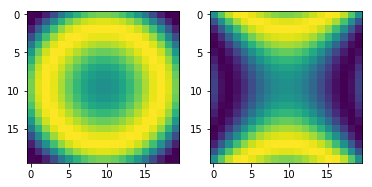

In [2]:
#Generate some random pictures
NPIX_X = 20
discr = np.linspace(0, 1, NPIX_X)
img1 = np.array([[(1 + np.sin(10*((x-0.5)**2+(y-0.5)**2)))/2 for y in discr] for x in discr])
# pic1 = np.array([[(x+y)/2 for y in discr] for x in discr])
img2 = np.array([[(1 + np.sin(10*((x-0.5)**2-(y-0.5)**2)))/2 for y in discr] for x in discr])

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

In [3]:
%%time

#######################################
# Simulation
#######################################

start_scope()
prefs.codegen.target = "numpy"

RUN_TIME_1_SIM = 1000*ms
RUN_TIME_TOT = 10 * RUN_TIME_1_SIM

#######################################
# Neurons
#######################################

N_INP = img1.shape[0] * img1.shape[1]
N_HID = N_INP
N_ERR = N_INP
print('Number of [INP, HID, ERR] neurons is', N_INP, N_HID, N_ERR)

# Fixed threshold neurons
LIF_V_TAU = 10*ms
LIF_V_TAU_INH = 2000*ms
LIF_V_0 = 0.0*mV
LIF_T_0 = 50.0*mV

# LIF neurons will be sparsely connected laterally
W_CONN_P_ENC = 0.1
W_CONN_P_DEC = 0.1
DV_SPIKE_POP = LIF_T_0 / 20
DV_SPIKE_SING = LIF_T_0 / 2


#######################################
# NOISE
#######################################
NOISE_FREQ = 2000*Hz

#######################################
# Input
#######################################

# Sync input voltage, so that for average threshold the leak would balance out the input
INPUT_FREQ_MAX = 2000*Hz

# INPUT_FREQ_MAX = NOISE_FREQ / (0.5*N_INP*W_CONN_P_ENC)
print("input freqnency", INPUT_FREQ_MAX)

# Generate input timed arrays
rates1 = INPUT_FREQ_MAX * np.ndarray.flatten(img1)
rates2 = INPUT_FREQ_MAX * np.ndarray.flatten(img2)
rates_all = np.vstack((rates1, rates2, rates1, rates2, rates1, rates2, rates1, rates2, rates1, rates2)) * Hz

# NOTE: The poisson rate is changed with time step dt, resulting in new input
rateTimedArray = TimedArray(rates_all, dt = RUN_TIME_1_SIM)


#######################################
# STDP
#######################################
TAU_PRE = 20*ms
TAU_POST = 20*ms
REL_W_MIN=0.0
REL_W_MAX=1.0
DW = 0.01 * Hz
Z_TRG = 8.0

# Two auxiliary variables track decaying trace of
# presynaptic and postsynaptic spikes
syn_eq = '''
dzpre/dt = -zpre/TAU_PRE : 1 (event-driven)
dzpost/dt = -zpost/TAU_POST : 1 (event-driven)
dw/dt = DW*zpre*(Z_TRG - zpost) : 1 (clock-driven)
'''

# On spike increase decaying variable by fixed amount
# Increase weight by the value of the decaying variable
# from the other side of the synapse
# Truncate weight if it exceeds maximum
syn_pre_eq = '''
zpre += 1
v_post += DV_SPIKE_POP * w
'''

syn_post_eq = '''
zpost += 1
'''


#######################################
# Brian2 classes
#######################################

# Create neuronal populations
#G_INP = PoissonGroup(N_INP, INPUT_FREQ_MAX * np.ndarray.flatten(img1))
G_INP = PoissonGroup(N_INP, rates="rateTimedArray(t, i)")
G_HID = brian2wrapper.NeuronGroupLIF(N_HID, LIF_V_0, LIF_T_0, LIF_V_TAU)
G_ERR = brian2wrapper.NeuronGroupLIF(N_ERR, LIF_V_0, LIF_T_0, LIF_V_TAU)
G_NOISE = PoissonGroup(N_ERR, NOISE_FREQ)

# Create synapses
S_ENC = Synapses(G_INP, G_HID, model='w : 1', on_pre='v_post += w*DV_SPIKE_POP', method='exact')
S_DEC = Synapses(G_HID, G_ERR, syn_eq, on_pre=syn_pre_eq, on_post=syn_post_eq)
S_INF = Synapses(G_INP, G_ERR, on_pre='v_post -= DV_SPIKE_SING', method='exact')
S_NOISE = Synapses(G_NOISE, G_ERR, on_pre='v_post += DV_SPIKE_SING', method='exact')

# Connect synapses:
# * Input and LIF one-to-one
# * LIF neurons to each other sparsely
S_ENC.connect(p=W_CONN_P_ENC) 
S_DEC.connect(p=W_CONN_P_DEC) 
S_INF.connect(j='i')
S_NOISE.connect(j='i')

# Initialize weights for neurons
S_ENC.w = np.random.uniform(REL_W_MIN, REL_W_MAX, len(S_ENC.w))
S_DEC.w = np.random.uniform(REL_W_MIN, REL_W_MAX, len(S_DEC.w))

#spikemon_inp = SpikeMonitor(G_INP)
statemon_g_err = StateMonitor(G_ERR, 'v', record=True, dt=1*ms)
statemon_s_dec = StateMonitor(S_DEC, 'w', record=True, dt=1*ms)
statemon_s_dec_rate = StateMonitor(S_DEC, 'zpost', record=True, dt=1*ms)


#######################################
# Run sim
#######################################

run(RUN_TIME_TOT)

Number of [INP, HID, ERR] neurons is 400 400 400
input freqnency 2. kHz


INFO       No numerical integration method specified for group 'synapses_1', using method 'euler' (took 0.01s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


CPU times: user 1min 49s, sys: 1.37 s, total: 1min 51s
Wall time: 1min 51s


8.297096939957399


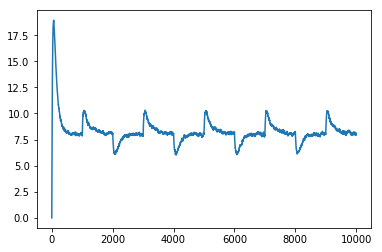

In [4]:
print(np.average(np.array(statemon_s_dec_rate.zpost)))

plt.figure()
plt.plot(np.average(np.array(statemon_s_dec_rate.zpost), axis=0))
plt.show()

# plt.figure()
# plt.plot(np.average(np.array(statemon_g_err.v), axis=0))
# plt.show()